In [1]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})

In [3]:
# Custom functions and tools 

import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

In [4]:
%%time
# load lite version of Gaia DR3 for quick cone searches
gaia_lite = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", columns=['ra',
                                                                                         'dec', 
                                                                                     "parallax", 
                                                                                         "phot_g_mean_mag"])
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates',
                                'teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower',
                                'logg_gspphot', 'logg_gspphot_lower', 'logg_gspphot_upper',
                                'mh_gspphot','mh_gspphot_lower', 'mh_gspphot_upper',
                                'distance_gspphot', 'distance_gspphot_lower','distance_gspphot_upper',
                                'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 
                                 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
                                'Norder', 'Npix', 'Dir'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 56.8 s, sys: 6.46 s, total: 1min 3s
Wall time: 1min 4s


In [5]:
%%time
# load pre-saved FG sample
_sample_hips = lsdb.read_hipscat("/astro/users/atzanida/epyc/ssd/users/atzanida/tmp/data_files/fg_sample")

CPU times: user 2.39 s, sys: 118 ms, total: 2.51 s
Wall time: 2.49 s


In [966]:
ztf_sources

,index,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
npartitions=311037,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834987686537986048,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# do not run
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")
# ran at 415

CPU times: user 943 ms, sys: 36.4 ms, total: 979 ms
Wall time: 983 ms


In [6]:
# do not run
%%time
_all_sky_object = _all_sky_object.compute()
# ran at 415

CPU times: user 1h 31min 4s, sys: 1h 32min 32s, total: 3h 3min 36s
Wall time: 20min 26s


In [7]:
# do not run
print (f"Number of unique sources: {len(_all_sky_object.index.unique())}")

Number of unique sources: 4833834


In [9]:
# do not run
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 3min 5s, sys: 8.83 s, total: 3min 14s
Wall time: 3min 13s


In [6]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 1min 21s, sys: 2.44 s, total: 1min 23s
Wall time: 1min 23s


In [11]:
# lazy loading sources
_sources

,ra_gaia_,dec_gaia_,parallax_gaia_,parallax_over_error_gaia_,bp_rp_gaia_,solution_id_gaia_,source_id_gaia_,pmra_gaia_,pmra_error_gaia_,pmdec_gaia_,pmdec_error_gaia_,parallax_error_gaia_,phot_g_mean_mag_gaia_,l_gaia_,b_gaia_,non_single_star_gaia_,classprob_dsc_combmod_galaxy_gaia_,classprob_dsc_combmod_star_gaia_,in_qso_candidates_gaia_,teff_gspphot_gaia_,teff_gspphot_upper_gaia_,teff_gspphot_lower_gaia_,logg_gspphot_gaia_,logg_gspphot_lower_gaia_,logg_gspphot_upper_gaia_,mh_gspphot_gaia_,mh_gspphot_lower_gaia_,mh_gspphot_upper_gaia_,distance_gspphot_gaia_,distance_gspphot_lower_gaia_,distance_gspphot_upper_gaia_,azero_gspphot_gaia_,azero_gspphot_lower_gaia_,azero_gspphot_upper_gaia_,ag_gspphot_gaia_,ebpminrp_gspphot_gaia_,ebpminrp_gspphot_lower_gaia_,ebpminrp_gspphot_upper_gaia_,Norder_gaia_,Npix_gaia_,Dir_gaia_,ps1_objid_ztf_dr14_,ra_ztf_dr14_,dec_ztf_dr14_,ps1_gMeanPSFMag_ztf_dr14_,ps1_rMeanPSFMag_ztf_dr14_,ps1_iMeanPSFMag_ztf_dr14_,nobs_g_ztf_dr14_,nobs_r_ztf_dr14_,nobs_i_ztf_dr14_,mean_mag_g_ztf_dr14_,mean_mag_r_ztf_dr14_,mean_mag_i_ztf_dr14_,Norder_ztf_dr14_,Dir_ztf_dr14_,Npix_ztf_dr14_,_DIST_,Norder_,Dir_,Npix_,index_ztf_source,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
npartitions=287241,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833861786631143424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [8]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(n_workers=48, threads_per_worker=1, memory_limit="24G")
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 48
Total threads: 48,Total memory: 1.05 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42688,Workers: 48
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 1.05 TiB
Comm: tcp://127.0.0.1:38674,Total threads: 1
Dashboard: http://127.0.0.1:36422/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:44535,


In [10]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


## Testing Functionalities

In [11]:
%%time
# demo tool estimate the nearest neighbour given ra, dec
my_tools.estimate_gaiadr3_density_async(131.1, 22.3)

CPU times: user 643 ms, sys: 355 ms, total: 999 ms
Wall time: 1.87 s


{'closest_bright_star_arcsec': 0.0075408123219372295,
 'closest_bright_star_mag': 16.448757,
 'closest_star_arcsec': 0.0075408123219372295,
 'closest_star_mag': 16.448757,
 'density_arcsec2': 6872.744168992514}

In [14]:
%%time
# know dipper
lc = ens.source.loc[160477522780225536]
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 16.4 s, sys: 2.52 s, total: 18.9 s
Wall time: 21.1 s


In [15]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], band_of_study='r', flag_good=0)

In [16]:
import astropy.stats as astro_stats
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

In [17]:
np.min(np.diff(time))

0.8480900000067777

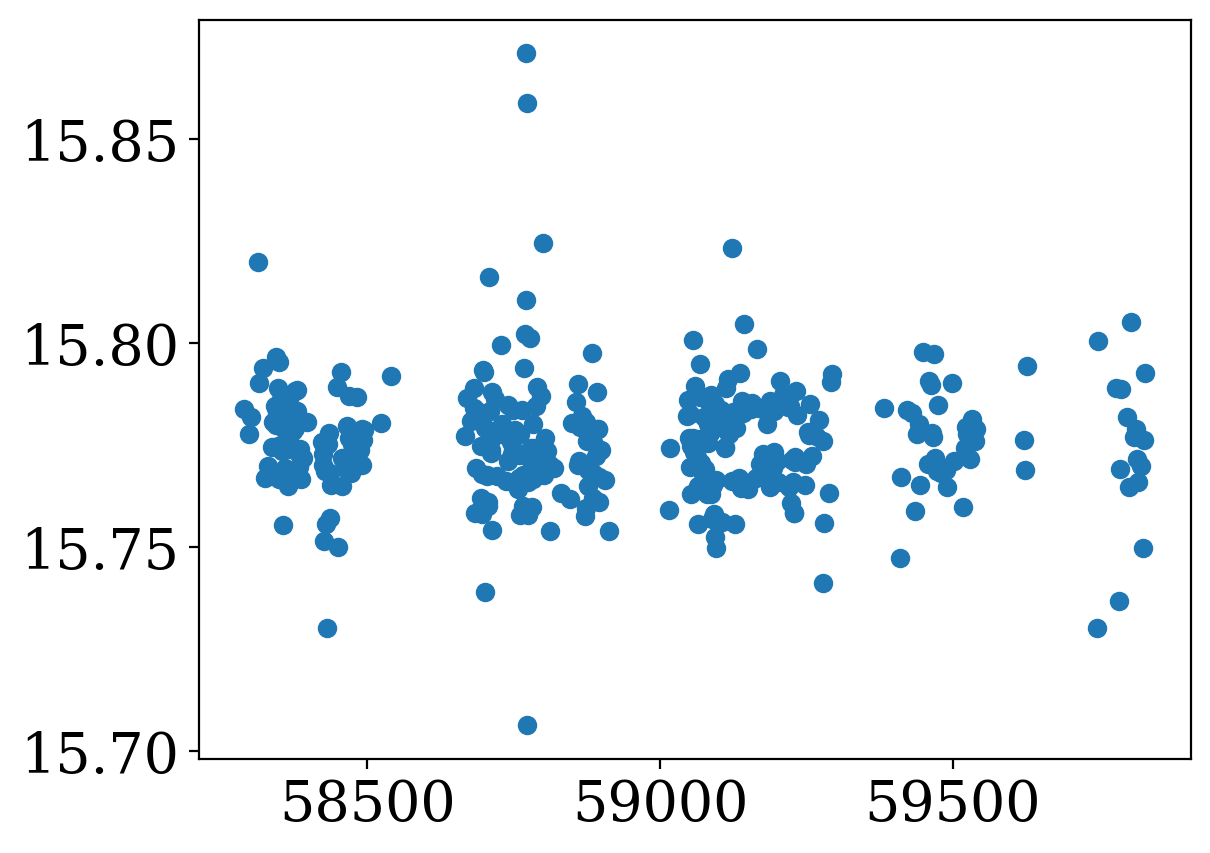

In [18]:
plt.scatter(time, mag)

In [19]:
hq = np.where(np.diff(time) < 1)[0] + 1

(15.879399681091309, 15.698074913024902)

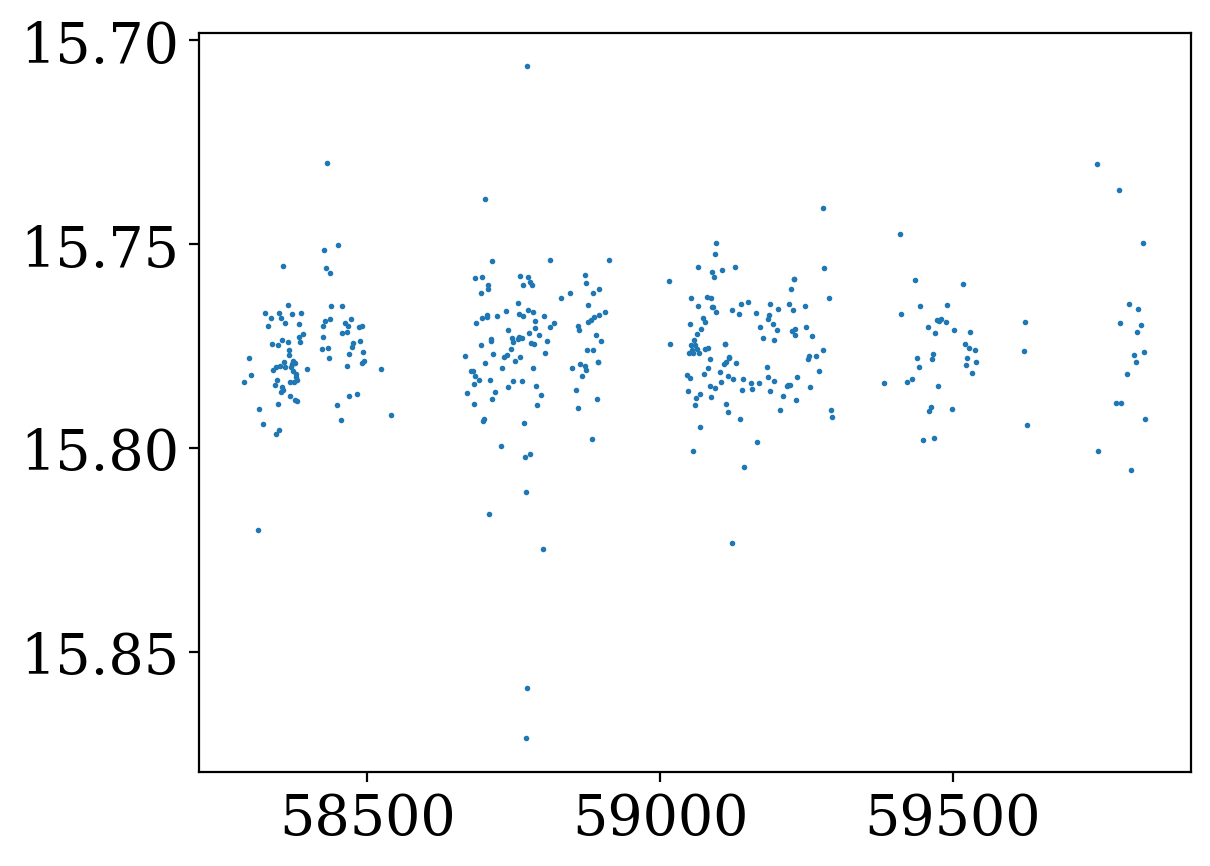

In [20]:
plt.scatter(time, mag, s=1)
plt.ylim(plt.ylim()[::-1])

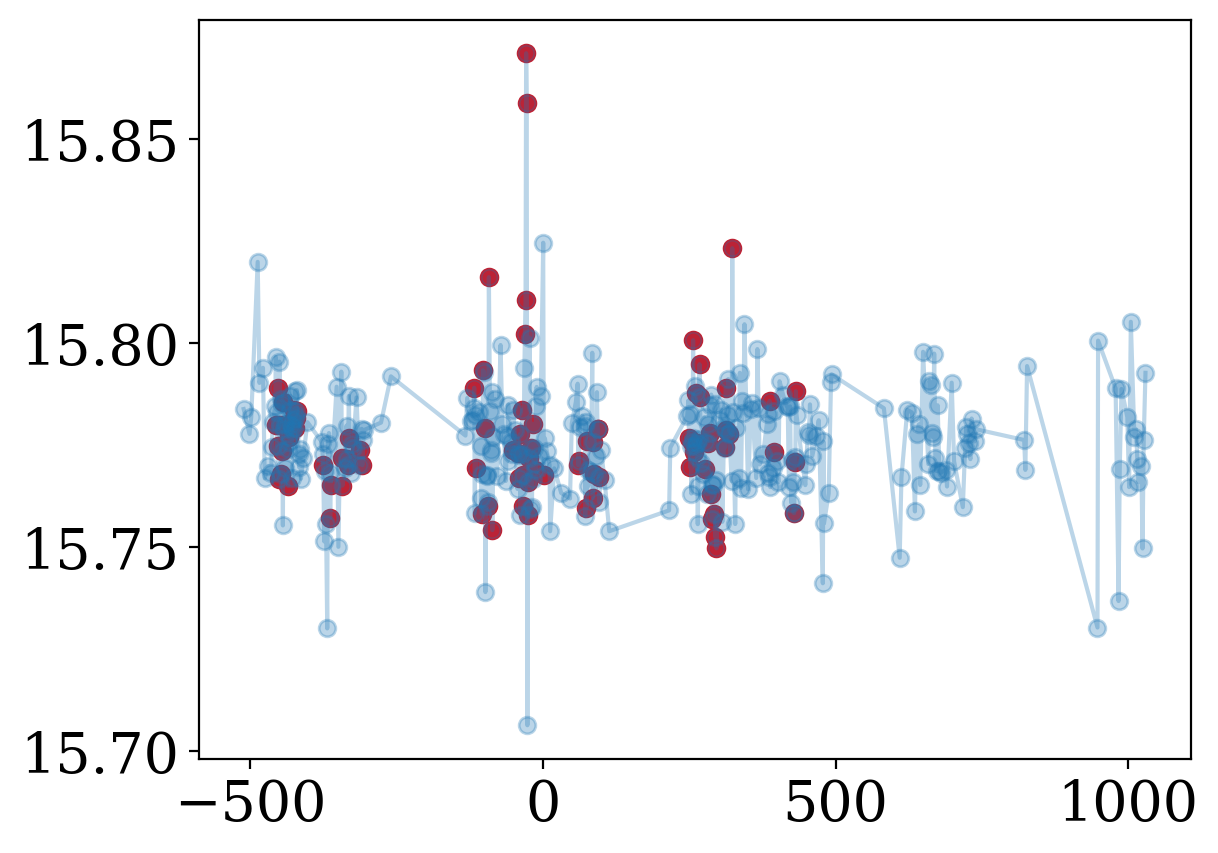

In [21]:
plt.scatter(time[hq]-58800, mag[hq], color='red', alpha=1)
plt.plot(time-58800, mag, 'o-', alpha=0.3)

#plt.grid()

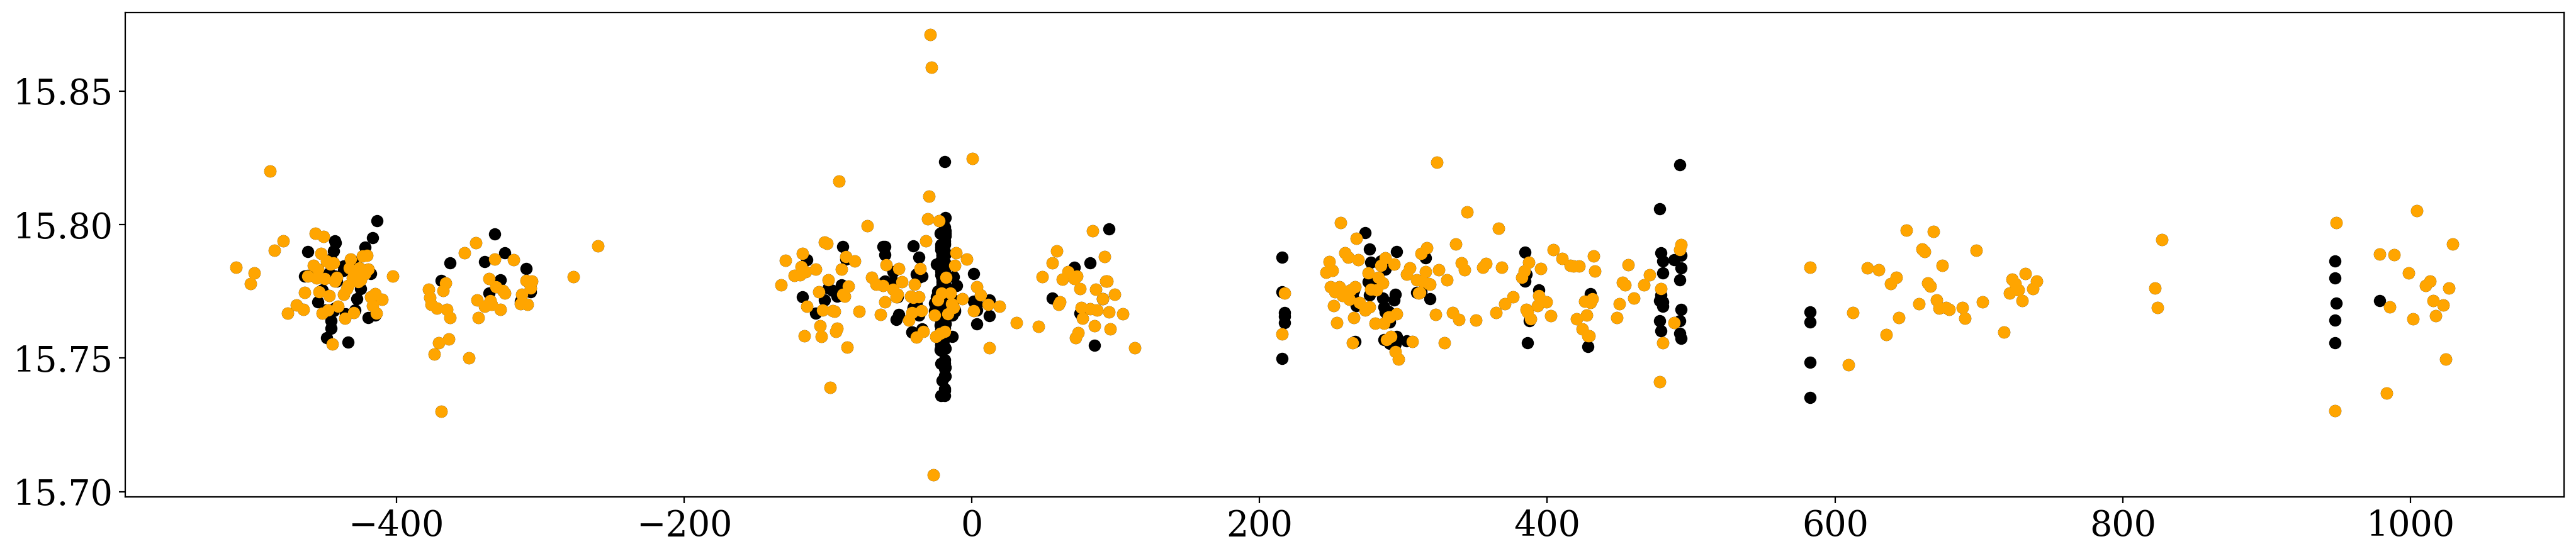

In [22]:
plt.figure(figsize=(25,5))
ww = (lc['catflags_ztf_source']==0) & (lc['band_ztf_source']=='r')

plt.scatter(lc['mjd_ztf_source'][ww]-58800,
                   lc['mag_ztf_source'][ww], color='k')

plt.scatter(time-58800, mag, color='orange')

In [24]:
np.load("bad_times.npy")

array([[58217.  , 58217.25],
       [58218.  , 58218.25],
       [58219.  , 58219.25],
       ...,
       [59822.25, 59822.5 ],
       [59824.25, 59824.5 ],
       [59826.25, 59826.5 ]])

In [12]:
column_names = [
    'biweight_scale',
    'frac_above_2_sigma',
    'Ndips',
    'rate',
    'chi2dof',
    'ADF_const',
    'ADF_const_trend',
    'ADF_pval_const',
    'ADF_pval_const_trend',
    'skew', 
    'kurtosis',
    'mad',
    'stetson_i',
    'stetson_j',
    'stetson_k',
    'invNeumann',
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'best_dip_score',
    'left_error',
    'right_error',
    'chi_square_gp',
    'gp_fun',
    'gp_status',
    'separation_btw_peaks',
    'closest_bright_star_arcsec',
    'closest_bright_star_mag',
    'closest_star_arcsec',
    'closest_star_mag',
    'density_arcsec2'
]

In [13]:
## test
print (evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0]))

NameError: name 'lc' is not defined

In [248]:
## test
print (evaluate(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0]))

biweight_scale                1.178585e-02
frac_above_2_sigma            1.902174e-02
Ndips                         1.000000e+00
rate                          6.489428e-04
chi2dof                       1.000087e+00
ADF_const                    -1.729642e+01
ADF_const_trend              -1.730609e+01
ADF_pval_const                5.663362e-30
ADF_pval_const_trend          0.000000e+00
skew                          9.776972e-01
kurtosis                      8.538677e+00
mad                           7.719517e-03
stetson_i                     5.211711e+01
stetson_j                     2.540011e+01
stetson_k                     6.891158e-01
invNeumann                    3.283832e-01
best_dip_power                5.708687e+00
best_dip_time_loc             5.877115e+04
best_dip_start                5.877414e+04
best_dip_end                  5.876516e+04
best_dip_dt                   1.188808e+00
best_dip_ndet                 7.000000e+00
best_dip_score               -4.479715e+00
left_error 

## Batch Calculation

In [262]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=column_names, dtype=float)

In [263]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    evaluate,
    'mjd_ztf_source', 'mag_ztf_source', 
    'magerr_ztf_source', 'catflags_ztf_source',
    'band_ztf_source', 'ra_ztf_source', 
    'dec_ztf_source',
    meta=my_meta,
    use_map=True, 
    compute=False
)

Using generated label, result_1, for a batch result.
CPU times: user 786 ms, sys: 201 ms, total: 987 ms
Wall time: 909 ms


In [253]:
for out in column_names:
    print (f"{out} = calc_['{out}'],")

biweight_scale = calc_['biweight_scale'],
frac_above_2_sigma = calc_['frac_above_2_sigma'],
Ndips = calc_['Ndips'],
rate = calc_['rate'],
chi2dof = calc_['chi2dof'],
ADF_const = calc_['ADF_const'],
ADF_const_trend = calc_['ADF_const_trend'],
ADF_pval_const = calc_['ADF_pval_const'],
ADF_pval_const_trend = calc_['ADF_pval_const_trend'],
skew = calc_['skew'],
kurtosis = calc_['kurtosis'],
mad = calc_['mad'],
stetson_i = calc_['stetson_i'],
stetson_j = calc_['stetson_j'],
stetson_k = calc_['stetson_k'],
invNeumann = calc_['invNeumann'],
best_dip_power = calc_['best_dip_power'],
best_dip_time_loc = calc_['best_dip_time_loc'],
best_dip_start = calc_['best_dip_start'],
best_dip_end = calc_['best_dip_end'],
best_dip_dt = calc_['best_dip_dt'],
best_dip_ndet = calc_['best_dip_ndet'],
best_dip_score = calc_['best_dip_score'],
left_error = calc_['left_error'],
right_error = calc_['right_error'],
chi_square_gp = calc_['chi_square_gp'],
gp_fun = calc_['gp_fun'],
gp_status = calc_['gp_status'],
sepa

In [264]:
%%time
ens.assign(table='object',
            biweight_scale = calc_['biweight_scale'],
            frac_above_2_sigma = calc_['frac_above_2_sigma'],
            Ndips = calc_['Ndips'],
            rate = calc_['rate'],
            chi2dof = calc_['chi2dof'],
            ADF_const = calc_['ADF_const'],
            ADF_const_trend = calc_['ADF_const_trend'],
            ADF_pval_const = calc_['ADF_pval_const'],
            ADF_pval_const_trend = calc_['ADF_pval_const_trend'],
            skew = calc_['skew'],
            kurtosis = calc_['kurtosis'],
            mad = calc_['mad'],
            stetson_i = calc_['stetson_i'],
            stetson_j = calc_['stetson_j'],
            stetson_k = calc_['stetson_k'],
            invNeumann = calc_['invNeumann'],
            best_dip_power = calc_['best_dip_power'],
            best_dip_time_loc = calc_['best_dip_time_loc'],
            best_dip_start = calc_['best_dip_start'],
            best_dip_end = calc_['best_dip_end'],
            best_dip_dt = calc_['best_dip_dt'],
            best_dip_ndet = calc_['best_dip_ndet'],
            best_dip_score = calc_['best_dip_score'],
            left_error = calc_['left_error'],
            right_error = calc_['right_error'],
            chi_square_gp = calc_['chi_square_gp'],
            gp_fun = calc_['gp_fun'],
            gp_status = calc_['gp_status'],
            separation_btw_peaks = calc_['separation_btw_peaks'],
            closest_bright_star_arcsec = calc_['closest_bright_star_arcsec'],
            closest_bright_star_mag = calc_['closest_bright_star_mag'],
            closest_star_arcsec = calc_['closest_star_arcsec'],
            closest_star_mag = calc_['closest_star_mag'],
            density_arcsec2 = calc_['density_arcsec2'])

CPU times: user 2min 33s, sys: 39.2 s, total: 3min 13s
Wall time: 2min 53s


In [256]:
ens.object

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,pmdec_error_gaia,parallax_error_gaia,phot_g_mean_mag_gaia,l_gaia,b_gaia,non_single_star_gaia,classprob_dsc_combmod_galaxy_gaia,classprob_dsc_combmod_star_gaia,in_qso_candidates_gaia,teff_gspphot_gaia,teff_gspphot_upper_gaia,teff_gspphot_lower_gaia,logg_gspphot_gaia,logg_gspphot_lower_gaia,logg_gspphot_upper_gaia,mh_gspphot_gaia,mh_gspphot_lower_gaia,mh_gspphot_upper_gaia,distance_gspphot_gaia,distance_gspphot_lower_gaia,distance_gspphot_upper_gaia,azero_gspphot_gaia,azero_gspphot_lower_gaia,azero_gspphot_upper_gaia,ag_gspphot_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,Norder_gaia,Npix_gaia,Dir_gaia,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix,biweight_scale,frac_above_2_sigma,Ndips,rate,chi2dof,ADF_const,ADF_const_trend,ADF_pval_const,ADF_pval_const_trend,skew,kurtosis,mad,stetson_i,stetson_j,stetson_k,invNeumann,best_dip_power,best_dip_time_loc,best_dip_start,best_dip_end,best_dip_dt,best_dip_ndet,best_dip_score,left_error,right_error,chi_square_gp,gp_fun,gp_status,separation_btw_peaks,closest_bright_star_arcsec,closest_bright_star_mag,closest_star_arcsec,closest_star_mag,density_arcsec2
npartitions=287277,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833861786631143424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [257]:
%%time
demo_table = ens.object.head(100, npartitions=10)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 17.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-01-31 15:01:27,967 - distributed.worker - WARNING - Compute Failed
Key:       ('lambda-e2ede16420d392efdc981d15a6e9cb3c', 5)
Function:  subgraph_callable-67607ce9-2ef5-438b-8f66-a33bf066
args:      ('TapeSourceFrame-14a4e14ee95b4becde64635a7fe39274', 'from-delayed-29b9012e845a30d50f9a3a0f972c1ea4',                    ra_gaia_  dec_gaia_  ...  Dir_ztf_source  Npix_ztf_source
_hipscat_index                          ...                                 
1415359626215424  47.220273   1.964825  ...               0                5
1415359626215424  47.220273   1.964825  ...               0                5
1415359626215424  47.220273   1.964825  ...               0                5
1415359626215424  47.220273   1.964825  ...  

TypeError: evaluate() got an unexpected keyword argument 'compute'

In [962]:
w = (demo_table['Ndips']>0) & (demo_table['best_dip_score']>50) & \
    (demo_table['closest_bright_star_arcsec']>0.001) & (demo_table['closest_bright_star_mag']>15) & \
    (demo_table['chi_square_gp']>0) & (demo_table['chi_square_gp']<150) & \
    (demo_table['best_dip_power']>7) & \
    (demo_table['best_dip_ndet']>0)

In [963]:
demo_table[w]

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,...,right_error,chi_square_gp,gp_fun,gp_status,separation_btw_peaks,closest_bright_star_arcsec,closest_bright_star_mag,closest_star_arcsec,closest_star_mag,density_arcsec2
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
64144503493099520,42.025266,14.109990,0.569902,12.622414,0.971536,1636148068921376768,32072243081883776,5.667276,0.052628,3.833100,...,0.007438,11.778459,1.0,0.073954,-0.002016,0.010227,15.429953,0.000020,15.788205,4581.829446
87851980893978624,55.007036,16.081296,0.595250,10.924937,1.105370,1636148068921376768,43925974863142912,4.872103,0.061618,-5.071064,...,0.003418,1.204415,1.0,0.224469,-0.669862,0.016148,15.810852,0.000009,16.229361,4581.829446
358668550329597952,65.388314,38.610963,1.094930,17.148130,1.773457,1636148068921376768,179334263500952448,4.097443,0.082996,-0.336843,...,0.013866,24.490351,1.0,4.814520,0.746873,0.009172,15.049505,0.000022,16.225807,24054.604591
366294310385090560,84.221346,35.698034,0.601723,11.461639,1.216539,1636148068921376768,183147133607168640,1.846448,0.057415,-2.871614,...,0.002717,48.451344,1.0,5.590187,-2.850311,0.012158,15.999073,0.000014,16.122231,41236.465014
369732514241052672,76.334988,34.146374,0.812877,15.059396,1.403766,1636148068921376768,184866254395965440,4.180284,0.063982,-3.645536,...,0.002558,3.579448,1.0,0.220115,-0.227512,0.015805,15.207442,0.000013,16.376425,34363.720845
384406850218491904,88.935109,42.004367,0.402521,6.890832,1.061482,1636148068921376768,192203398567036288,0.466664,0.054650,-5.272369,...,0.005805,60.678548,1.0,12.032120,1.864160,0.008956,15.851917,0.000040,16.345016,29781.891399
385553701986631680,86.577100,41.925838,0.345211,5.794281,1.181616,1636148068921376768,192776828239951872,-0.238674,0.070893,-0.059389,...,0.002679,149.694990,1.0,11.486158,48.563100,0.014876,15.324016,0.000018,16.510876,38945.550291
393498551386112000,89.886833,45.660381,0.491205,8.839048,0.933284,1636148068921376768,196749260671192192,0.059756,0.052970,-0.959378,...,0.003883,15.029822,1.0,0.087085,-0.356223,0.007670,15.354605,0.000035,16.111189,27490.976676
410914142736613376,74.965748,44.638249,0.983362,18.036420,1.523598,1636148068921376768,205457049167677184,4.102879,0.062988,-27.800307,...,0.006721,11.419360,1.0,0.917466,-0.421996,0.011498,15.857928,0.000003,16.182533,53836.495990


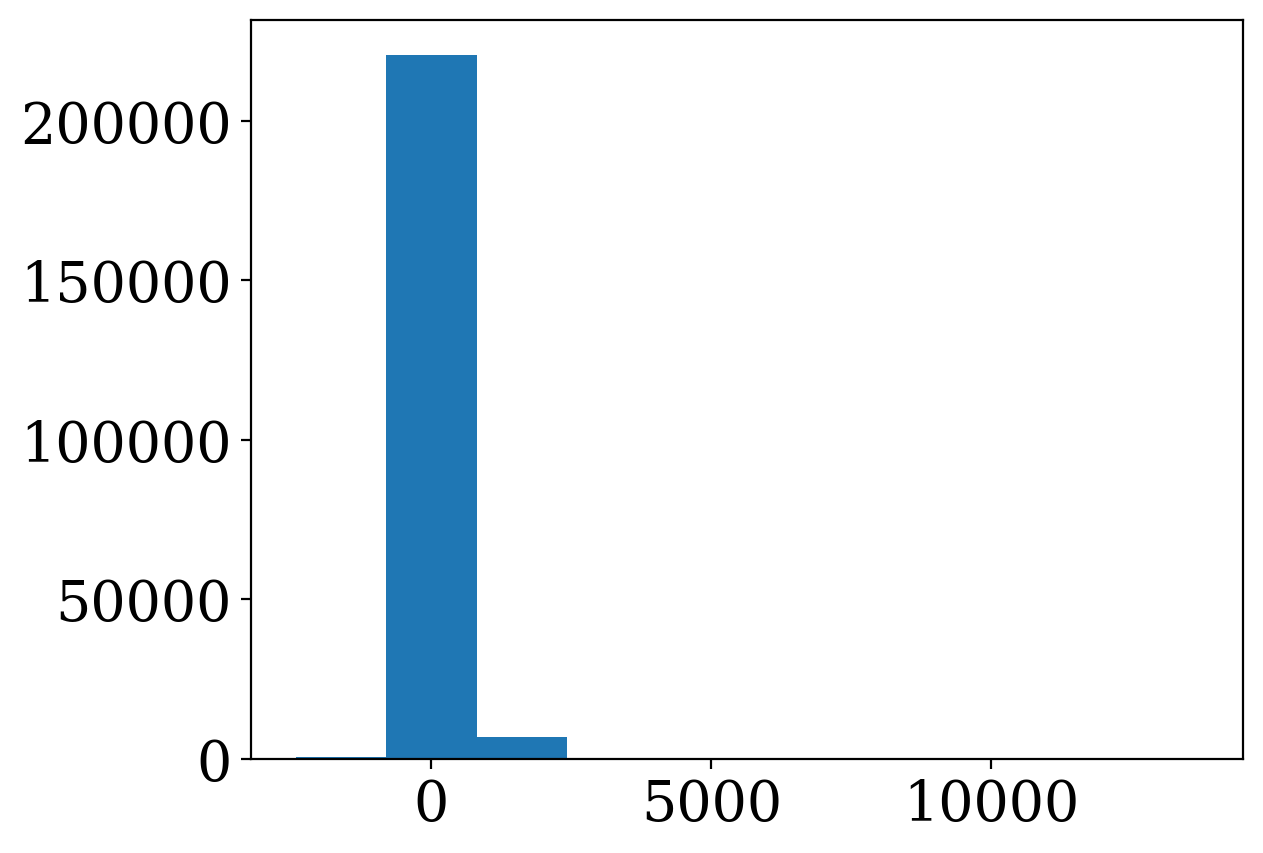

In [856]:
_ = plt.hist(demo_table['chi_square_gp'])

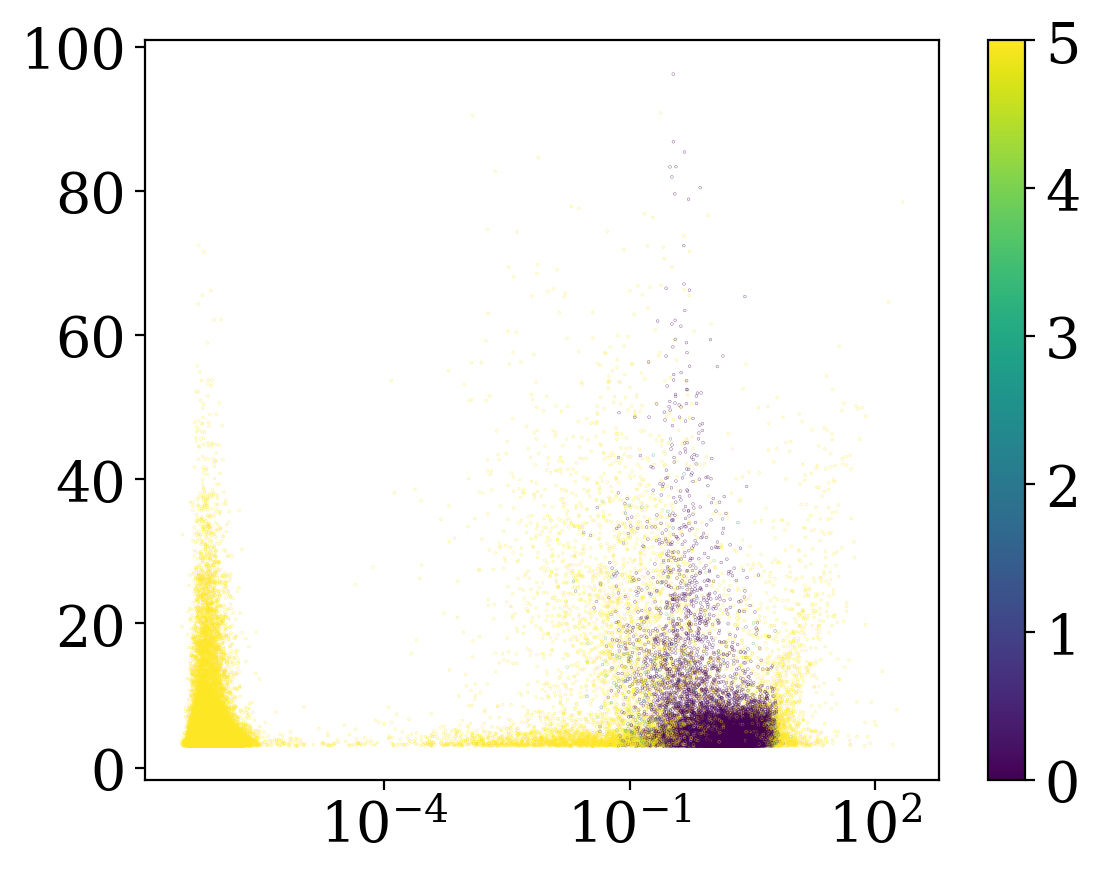

In [859]:
plt.scatter(demo_table['gp_status'], 
            demo_table['best_dip_power'], s=0.01, c=demo_table['chi_square_gp'], 
           vmin=0, vmax=5)
plt.colorbar()

plt.xscale('log')

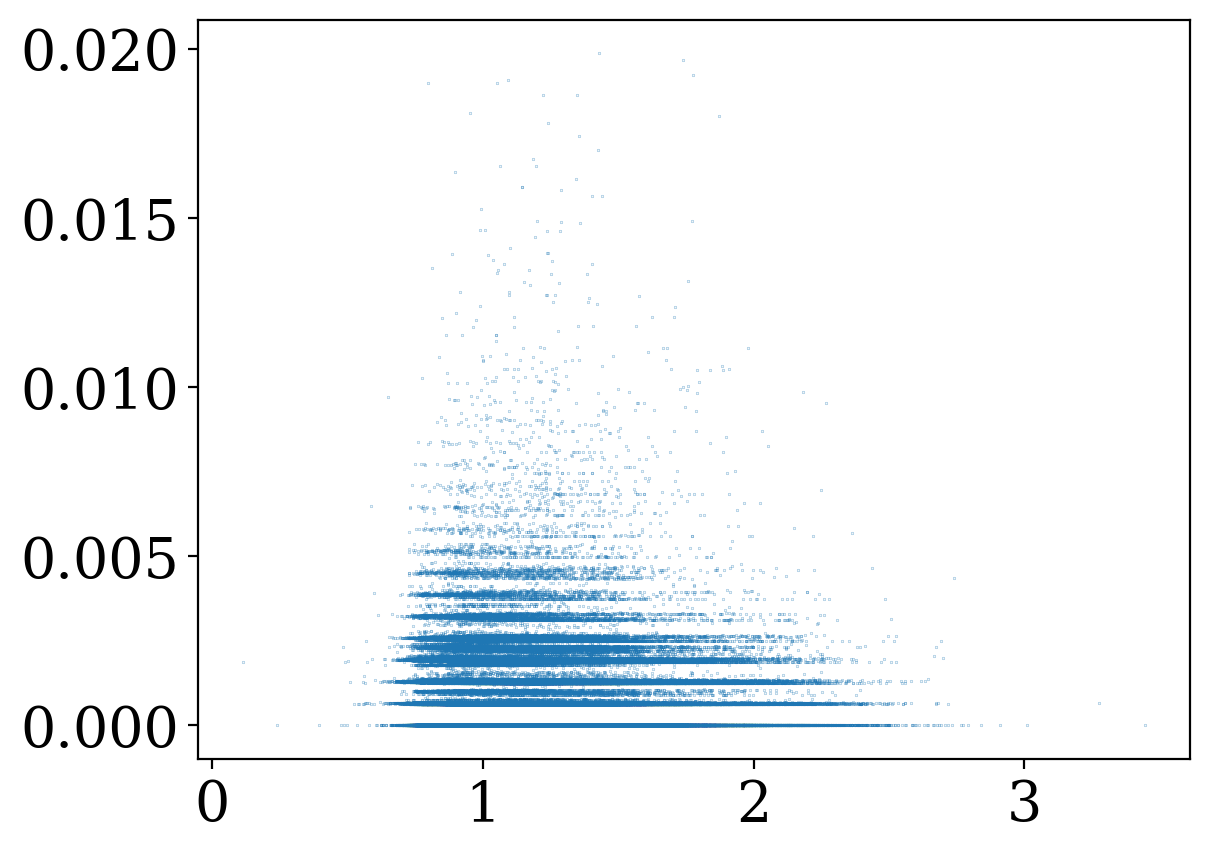

In [843]:
plt.scatter(demo_table['bp_rp_gaia'], 
            demo_table['rate'], s=0.01)

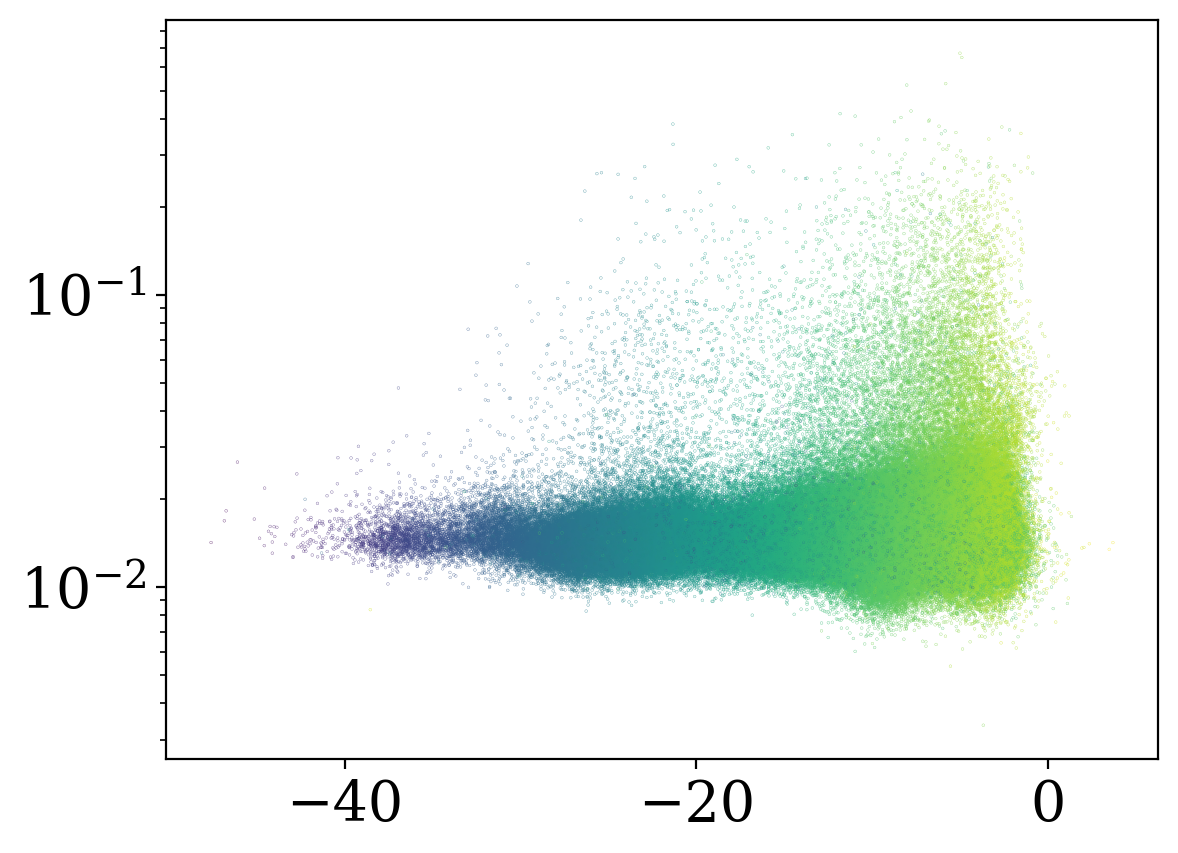

In [835]:
plt.scatter(demo_table['ADF_const'], 
            demo_table['biweight_scale'],
            s=0.01, c=demo_table['ADF_const_trend'])
plt.yscale('log')

In [ ]:
%%time
full_table = ens.object.head(4_833_834, npartitions=287_241)
# ran at 12:04am jan 9

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 2.57 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [811]:
full_table

NameError: name 'full_table' is not defined

In [860]:
%%time
lc = ens.source.loc[501473206847143936]

CPU times: user 161 ms, sys: 144 ms, total: 305 ms
Wall time: 285 ms


In [862]:
%%time
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


KeyboardInterrupt: 

## Source Examination

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


KeyboardInterrupt: 

(16.369356907904148, 16.166746828705072)

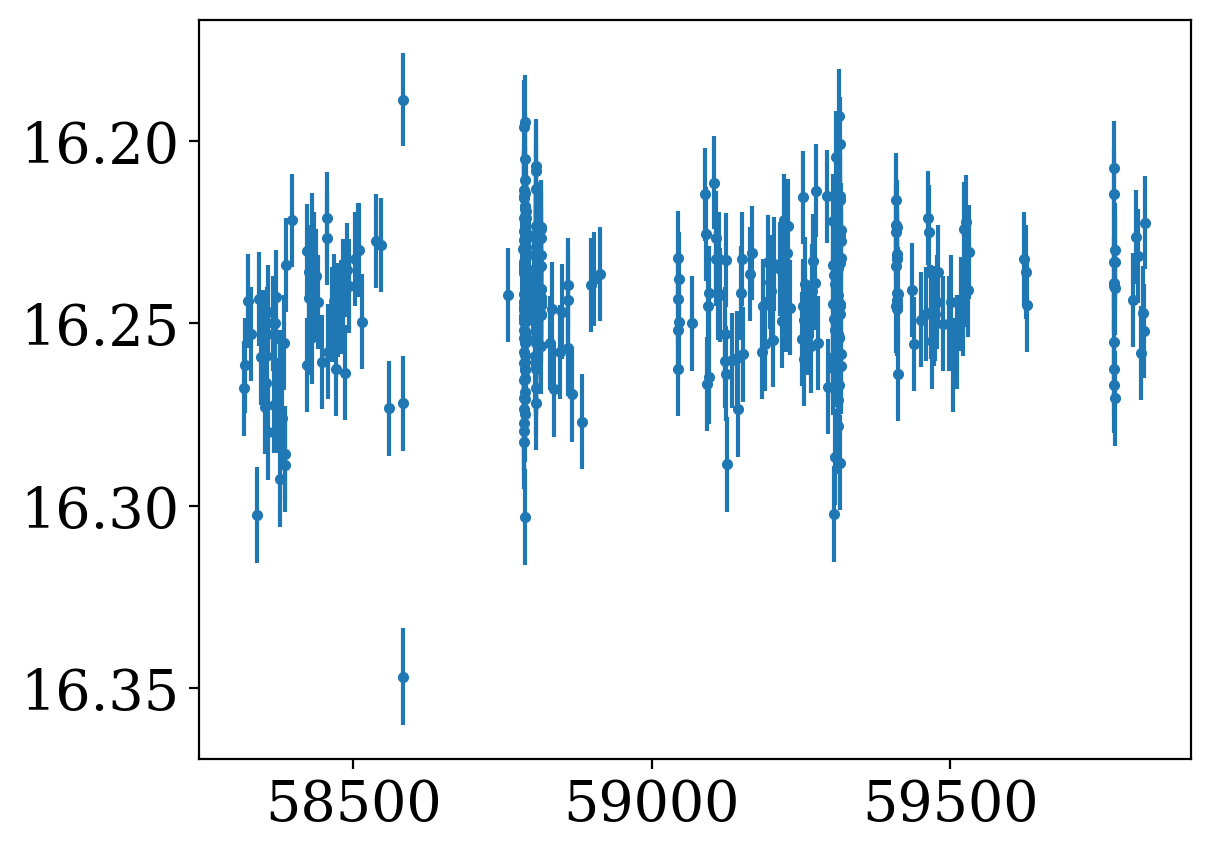

In [827]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], band_of_study='r', flag_good=0)

plt.errorbar(time, mag, magerr, fmt='.')
plt.ylim(plt.ylim()[::-1])


(16.369356907904148, 16.166746828705072)

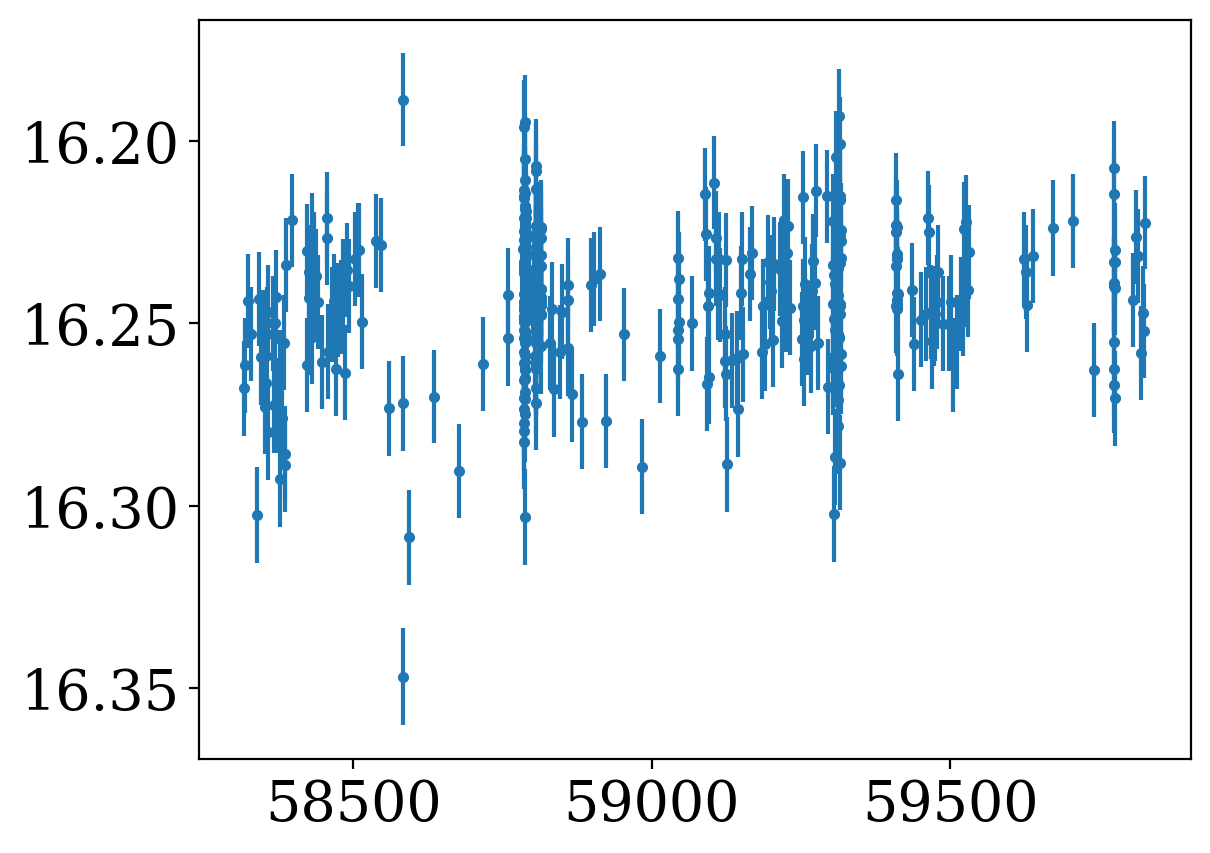

In [828]:
time, mag, magerr = my_tools.fill_gaps(time, mag, magerr, num_points=5, max_gap_days=95, window_size=0)
plt.errorbar(time, mag, magerr, fmt='.')
plt.ylim(plt.ylim()[::-1])


In [564]:
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

In [565]:
# Peak detection summary per light curve
peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=5,  peak_close_rmv=15, pk_2_pk_cut=250)

# Select best peak candidate with at least 3 points in the dip
bp = dip_pipeline.best_peak_detector(peak_detections, min_in_dip=5)

No dip is found within the minimum number of detections.


In [965]:
%%time
lc = lc.compute()


KeyboardInterrupt



In [10]:
import pandas as pd

In [140]:
len(pd.read_csv("temp/alias_dips.csv"))

FileNotFoundError: [Errno 2] No such file or directory: 'temp/alias_dips.csv'

In [139]:
!rm -rf temp/alias_dips.csv

In [108]:
!ls temp/

alias_dips.csv


In [88]:
!ls temp/

alias_dips.csv
